In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./BNB.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2017-11-09,2.05314,2.17423,1.89394,1.99077,19192200.0,USD
2017-11-10,2.00773,2.06947,1.64478,1.79684,11155000.0,USD
2017-11-11,1.78628,1.91775,1.61429,1.67047,8178150.0,USD
2017-11-12,1.66889,1.67280,1.46256,1.51969,15298700.0,USD
2017-11-13,1.52601,1.73502,1.51760,1.68662,12238800.0,USD


In [3]:
df.tail()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-08-18,306.796478,310.187958,297.026428,298.141235,1.041815e+09,USD
2022-08-19,298.152771,298.190704,278.579437,279.718719,1.598319e+09,USD
2022-08-20,279.620117,288.905518,278.332062,283.693146,1.315368e+09,USD
2022-08-21,283.639099,303.657928,283.639099,302.056274,1.249206e+09,USD
2022-08-23,300.100708,301.066559,296.353302,297.207642,1.452279e+09,USD


In [4]:
# Extract the bnb data only
bnb=df
# Drop some columns
bnb.drop(['Volume', 'Currency'],axis=1,inplace=True) 

In [5]:
bnb.head()

,Open,High,Low,Close
Date,,,,
2017-11-09,2.05314,2.17423,1.89394,1.99077
2017-11-10,2.00773,2.06947,1.64478,1.79684
2017-11-11,1.78628,1.91775,1.61429,1.67047
2017-11-12,1.66889,1.67280,1.46256,1.51969
2017-11-13,1.52601,1.73502,1.51760,1.68662


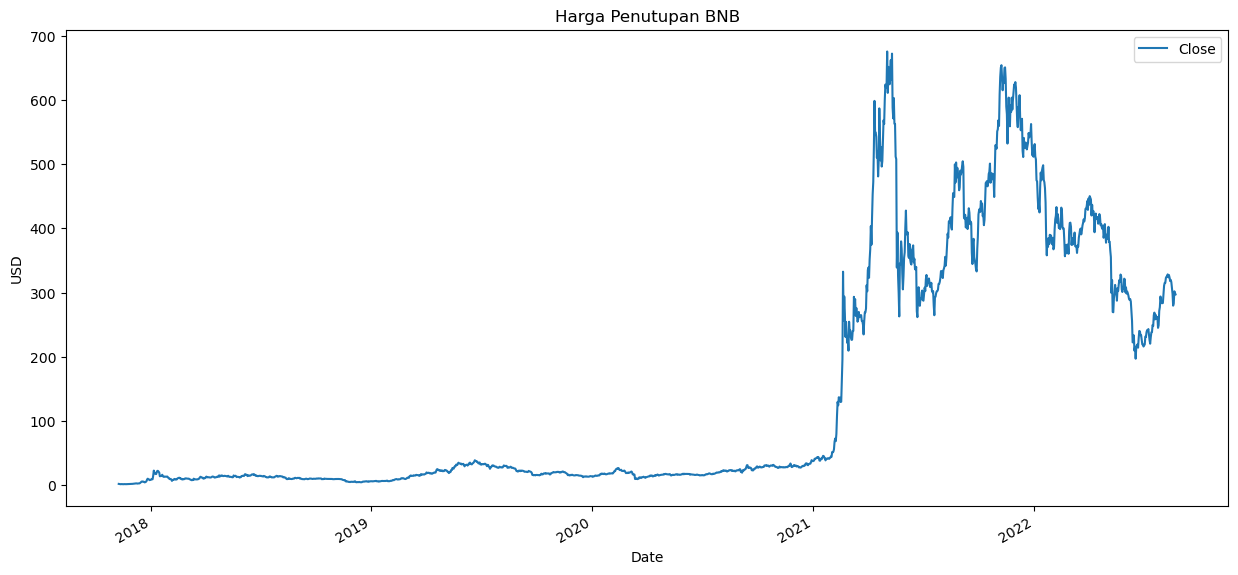

In [6]:
plt.figure(figsize=(15,7))
bnb.Close.plot()
plt.legend()
plt.title('Harga Penutupan BNB')
plt.ylabel('USD')
plt.show()

# Monthly Forecasting

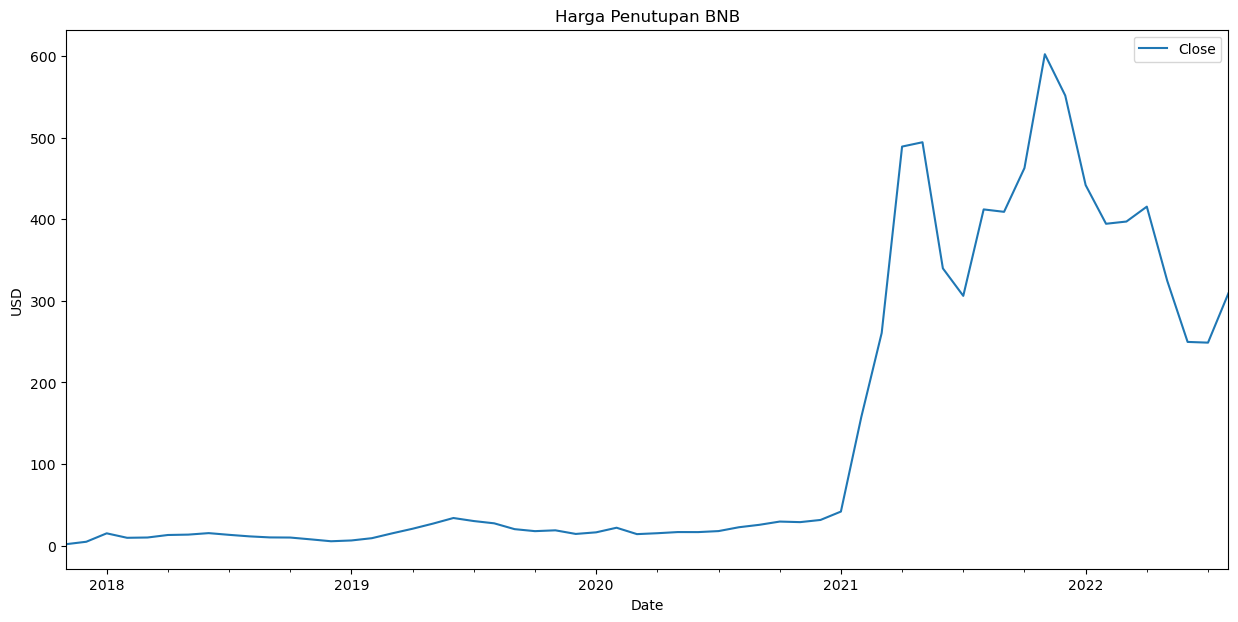

In [7]:
# Resampling to monthly frequency
bnb_month = bnb.resample('M').mean()

plt.figure(figsize=(15,7))
bnb_month.Close.plot()
plt.legend()
plt.title('Harga Penutupan BNB')
plt.ylabel('USD')
plt.show()

### Stationarity check and Seasonal decomposition
Jika deret waktu stasioner, ini menunjukkan kurangnya tren luas (perubahan rata-rata dan varian dari waktu ke waktu) dalam data. Hal ini penting sebagai pertimbangan dalam peramalan runtun waktu.

Dickey–Fuller test: p=0.781261


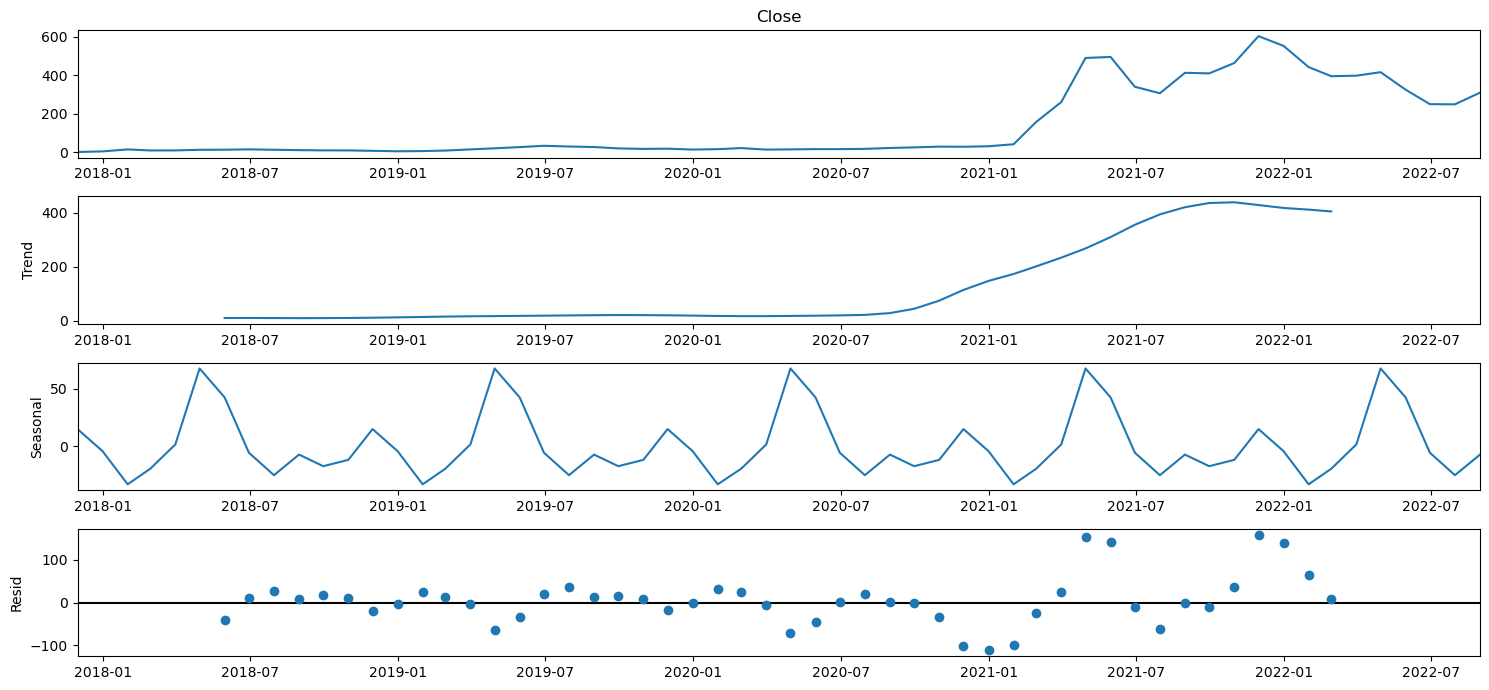

In [8]:
#seasonal_decompose(bnb_month.close, freq=12).plot()
seasonal_decompose(bnb_month.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(bnb_month.Close)[1])
plt.show()

nilai p mengindikasikan bahwa series belum stasioner.

### Box-Cox Transformation 

Mari gunakan transformasi Box-Cox untuk menekan beberapa varian.

Transformasi Box-Cox adalah keluarga transformasi daya yang diindeks oleh parameter lambda. Setiap kali Anda menggunakannya, parameter perlu diestimasi dari data. Dalam runtun waktu, proses dapat memiliki varian yang tidak konstan. jika varians berubah dengan waktu, prosesnya tidak stasioner. Seringkali diinginkan untuk mengubah deret waktu agar stasioner. Terkadang setelah menerapkan Box-Cox dengan nilai lambda tertentu, prosesnya mungkin terlihat stasioner. Kadang-kadang mungkin bahwa bahkan jika setelah menerapkan transformasi Box-Cox rangkaian tampaknya tidak stasioner, diagnostik dari pemodelan ARIMA kemudian dapat digunakan untuk memutuskan apakah pembedaan atau pembedaan musiman mungkin berguna untuk menghilangkan tren polinomial atau tren musiman. . Setelah itu hasilnya mungkin model ARMA yang stasioner. Jika diagnostik mengkonfirmasi pesanan p an q untuk model ARMA, maka parameter AR dan MA dapat diestimasi.

In [9]:
# Box-Cox Transformations
bnb_month['close_box'], lmbda = stats.boxcox(bnb_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(bnb_month.close_box)[1])

Dickey–Fuller test: p=0.674995


Nilai p masih belum stasioner

### Differencing 

Saat membuat model untuk meramalkan data deret waktu (seperti ARIMA), langkah pra-pemrosesan lainnya adalah membedakan data (menghitung secara berurutan xt−xt−1) hingga kita mencapai titik di mana deret tersebut stasioner. Model memperhitungkan osilasi tetapi tidak untuk tren, dan oleh karena itu, memperhitungkan tren dengan membedakan memungkinkan kita untuk menggunakan model yang memperhitungkan osilasi.

Setelah model dibangun, kita dapat memperhitungkan tren secara terpisah, dengan menambahkan tren berdasarkan komponen.

#### Seasonal differentiation 

Salah satu metode diferensiasi data adalah diferensiasi musiman, yang melibatkan penghitungan selisih antara pengamatan dan pengamatan yang sesuai pada tahun sebelumnya.

In [10]:
bnb_month['box_diff_seasonal_12'] = bnb_month.close_box - bnb_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(bnb_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.128627


Nilai p masih belum stasioner

In [11]:
# Seasonal differentiation (3 months)
bnb_month['box_diff_seasonal_3'] = bnb_month.close_box - bnb_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(bnb_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.005136


Nilai p mengindikasikan series sudah stasioner karena p-value lebih kecil dari level alpha = 0.05.

#### Regular differentiation 

Kadang-kadang mungkin diperlukan untuk membedakan data untuk kedua kalinya untuk mendapatkan deret waktu yang stasioner, yang disebut sebagai pembeda urutan kedua.

Dickey–Fuller test: p=0.000004


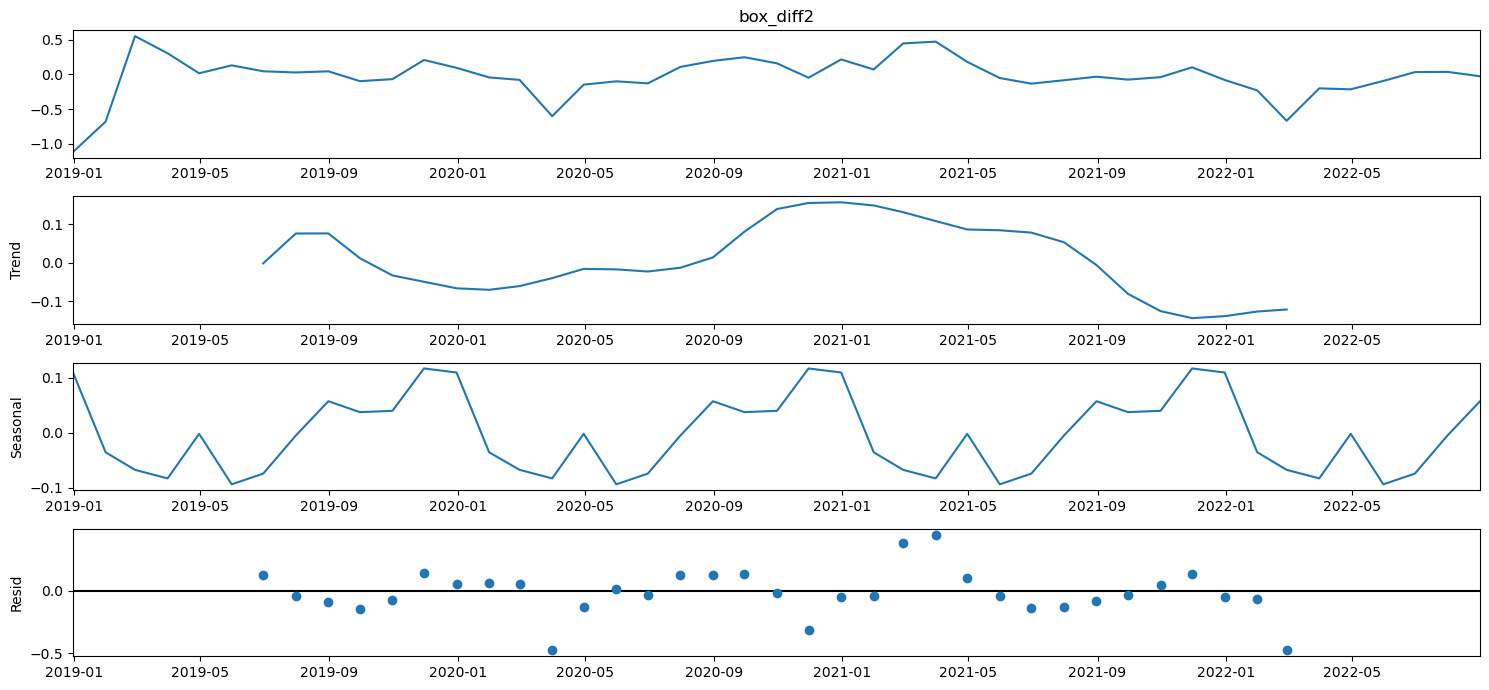

In [12]:
# Regular differentiation
bnb_month['box_diff2'] = bnb_month.box_diff_seasonal_12 - bnb_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(bnb_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(bnb_month.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

### Autocorrelation 

Autokorelasi adalah korelasi suatu time series dengan time series yang sama lag. Ini merangkum kekuatan hubungan dengan pengamatan dalam deret waktu dengan pengamatan pada langkah waktu sebelumnya.

Kita membuat plot faktor autokorelasi (ACF) dan faktor autokorelasi parsial (PACF) untuk mengidentifikasi pola pada data di atas yang stasioner pada rata-rata dan varians. Idenya adalah untuk mengidentifikasi keberadaan komponen AR dan MA dalam residu.

Date
2019-01-31      6.321450
2019-02-28      9.101428
2019-03-31     15.060067
2019-04-30     20.703582
2019-05-31     26.985650
2019-06-30     33.848594
2019-07-31     30.122802
2019-08-31     27.334428
2019-09-30     20.186121
2019-10-31     17.741821
2019-11-30     18.752447
2019-12-31     14.316846
2020-01-31     16.287440
2020-02-29     21.925773
2020-03-31     14.085149
2020-04-30     15.199917
2020-05-31     16.612913
2020-06-30     16.570955
2020-07-31     17.812052
2020-08-31     22.530665
2020-09-30     25.499655
2020-10-31     29.481324
2020-11-30     28.793736
2020-12-31     31.463888
2021-01-31     41.749218
2021-02-28    157.668050
2021-03-31    260.716174
2021-04-30    489.268384
2021-05-31    494.574970
2021-06-30    339.938113
2021-07-31    306.218245
2021-08-31    412.220612
2021-09-30    409.254601
2021-10-31    462.934745
2021-11-30    602.498883
2021-12-31    551.838040
2022-01-31    442.029668
2022-02-28    394.614115
2022-03-31    397.352503
2022-04-30    415.60

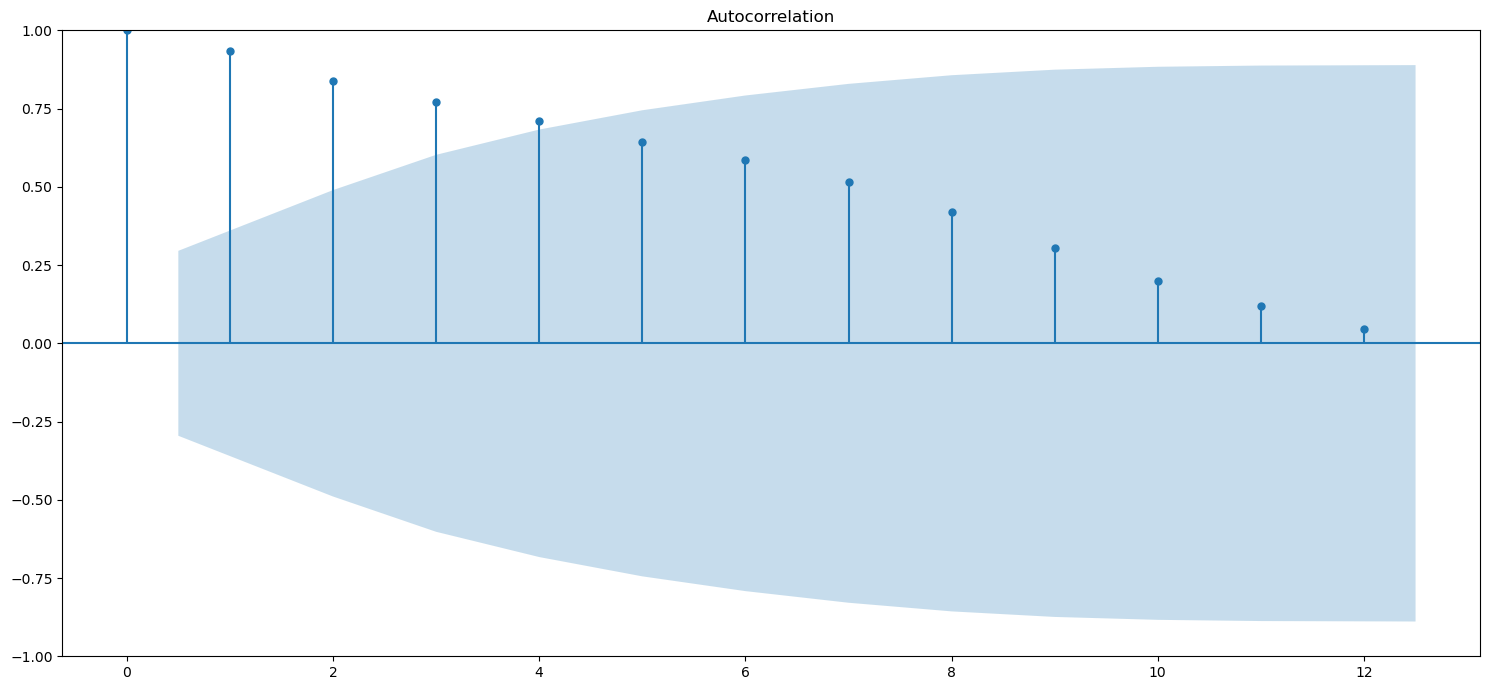

In [13]:
#autocorrelation_plot(bnb_month.close)
print(bnb_month.Close[14:])
plot_acf(bnb_month.Close[14:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

Ada korelasi positif dengan 10 kelambatan pertama yang mungkin signifikan untuk 2-3 kelambatan pertama.

Titik awal yang baik untuk parameter AR model mungkin 3.

Mari kita coba autokorelasi pada perbedaan ...

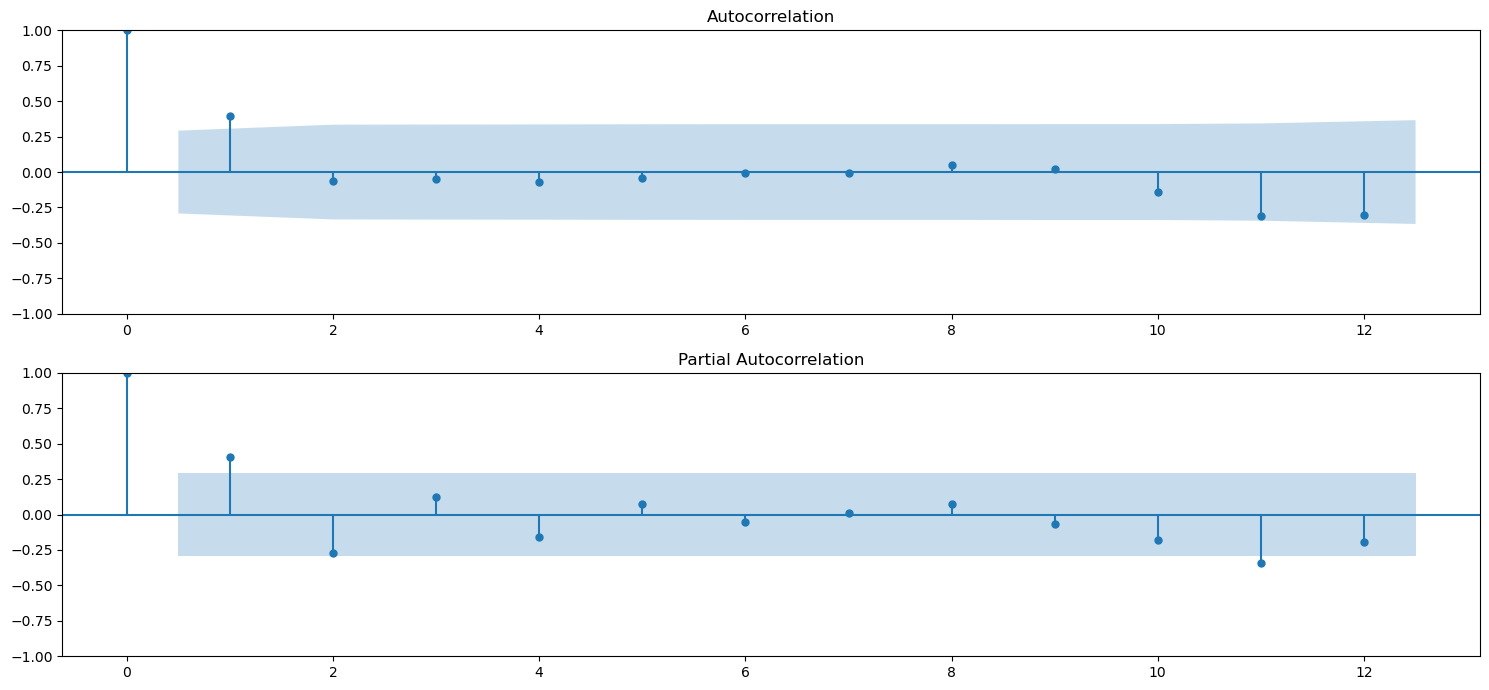

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(bnb_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(bnb_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(bnb_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(bnb_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

Tidak banyak lonjakan pada plot di luar zona yang tidak signifikan (diarsir) sehingga mungkin tidak tersedia cukup informasi dalam residu untuk diekstrak oleh model AR dan MA.

### ARIMA Model 
AutoRegressive Integrated Moving Average

Model ARIMA dilambangkan dengan notasi ARIMA(p, d, q). Parameter ini memperhitungkan musim, tren, dan noise dalam kumpulan data:

p - jumlah observasi lag untuk disertakan dalam model, atau urutan lag. (AR)<br>
d - berapa kali pengamatan mentah dibedakan, atau tingkat perbedaan. (Saya)<br>
q - ukuran jendela rata-rata bergerak, juga disebut urutan rata-rata bergerak.(MA)

Model regresi linier dibangun termasuk jumlah dan jenis istilah yang ditentukan, dan data disiapkan dengan tingkat perbedaan untuk membuatnya stasioner, yaitu untuk menghilangkan tren dan struktur musiman yang berdampak negatif pada model regresi. Nilai 0 untuk parameter menunjukkan untuk tidak menggunakan elemen model tersebut.

#### Parameter Selection

Kami akan mengeksplorasi kombinasi parameter yang berbeda secara iteratif. Untuk setiap kombinasi, kami menyesuaikan model ARIMA baru dengan SARIMAX() dan menilai kualitasnya secara keseluruhan.

Kami akan menggunakan nilai AIC (Akaike Information Criterion), dikembalikan dengan model ARIMA yang dipasang menggunakan statsmodels. AIC mengukur seberapa cocok model dengan data sambil mempertimbangkan kompleksitas keseluruhan model. Model yang sangat cocok dengan data saat menggunakan banyak fitur akan diberi skor AIC yang lebih besar daripada model yang menggunakan lebih sedikit fitur untuk mencapai kesesuaian yang sama. Oleh karena itu, kami tertarik untuk menemukan model yang menghasilkan nilai AIC terendah.

In [15]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(bnb_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Perhatikan bahwa beberapa kombinasi parameter dapat menyebabkan salah spesifikasi numerik dan kami secara eksplisit menonaktifkan pesan peringatan untuk menghindari kelebihan pesan peringatan. Kesalahan spesifikasi ini juga dapat menyebabkan kesalahan dan melontarkan pengecualian, jadi kami menangkap pengecualian ini dan hanya mencetak kombinasi parameter yang menyebabkan masalah ini.

In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
1     (0, 1) -20.714844
3     (1, 0) -18.757509
4     (1, 1) -18.736693
2     (0, 2) -18.733173
8     (2, 2) -18.217278


Perhatikan AIC negatif tetapi ini bukan masalah.

Biasanya, AIC positif; namun, itu dapat digeser oleh konstanta aditif apa pun, dan beberapa pergeseran dapat menghasilkan nilai AIC negatif. Ini bukan ukuran absolut dari nilai AIC, itu adalah nilai relatif dari rangkaian model yang dipertimbangkan, dan khususnya perbedaan antara nilai AIC, yang penting.

In [17]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   58
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  12.357
Date:                Tue, 31 Jan 2023   AIC                            -20.715
Time:                        14:52:41   BIC                            -16.629
Sample:                    11-30-2017   HQIC                           -19.127
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5261      0.113      4.649      0.000       0.304       0.748
sigma2         0.0377      0.005      8.198      0.000       0.029       0.047
Ljung-Box (L1) (Q):                   0.47   Jarque-

### Analysis of Results 

Kolom koefisien menunjukkan bobot dari setiap fitur dan bagaimana masing-masing memengaruhi runtun waktu. P>|z| kolom menginformasikan kepada kita pentingnya setiap bobot fitur. Di sini, setiap bobot memiliki nilai-p lebih rendah atau mendekati 0,05, jadi masuk akal untuk mempertahankan semuanya dalam model kita.

Saat menyesuaikan model ARIMA musiman (dan model lainnya dalam hal ini), penting untuk menjalankan diagnostik model untuk memastikan tidak ada asumsi yang dibuat oleh model yang dilanggar. Objek plot_diagnostics memungkinkan kita membuat diagnostik model dengan cepat dan menyelidiki perilaku yang tidak biasa.

In [18]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


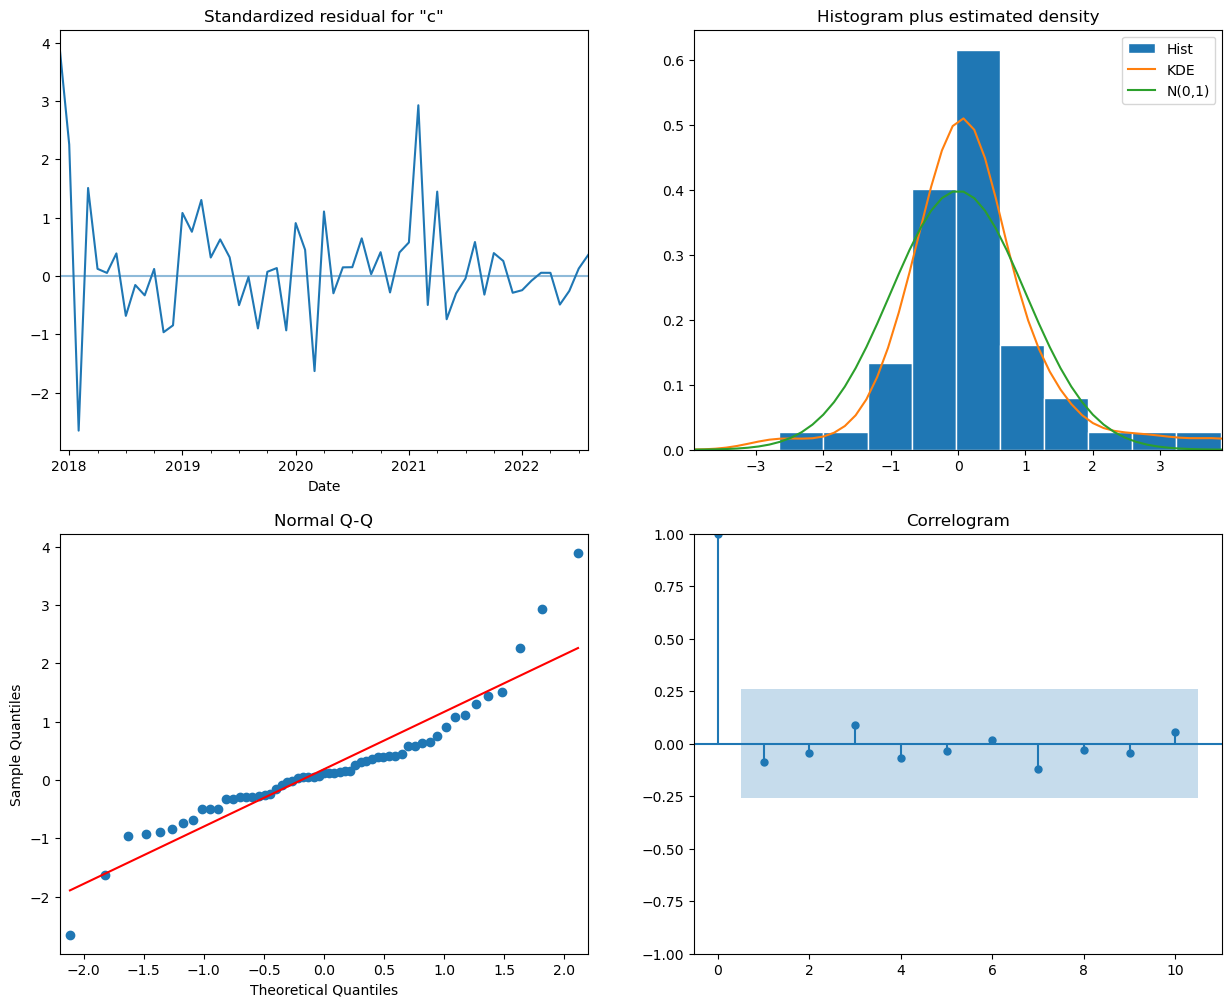

In [19]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Perhatian utama kami adalah untuk memastikan bahwa residu model kami tidak berkorelasi dan terdistribusi normal dengan rata-rata nol. Jika model ARIMA musiman tidak memenuhi sifat-sifat ini, ini merupakan indikasi yang baik bahwa model tersebut dapat ditingkatkan lebih lanjut.

Di histogram (kanan atas), garis KDE harus mengikuti garis N(0,1) (distribusi normal dengan rata-rata 0, standar deviasi 1) secara dekat. Ini merupakan indikasi apakah residual terdistribusi secara normal atau tidak.

Dalam Q-Q-plot distribusi urutan residu (titik biru) harus mengikuti tren linier sampel yang diambil dari distribusi normal standar dengan N(0, 1). Sekali lagi, ini merupakan indikasi apakah residual terdistribusi secara normal.

Plot residual standar tidak menampilkan musiman yang jelas.
Hal ini dikonfirmasi oleh plot autokorelasi, yang menunjukkan bahwa residual runtun waktu memiliki korelasi yang rendah dengan versi lag dari dirinya sendiri.

### Prediction

In [20]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

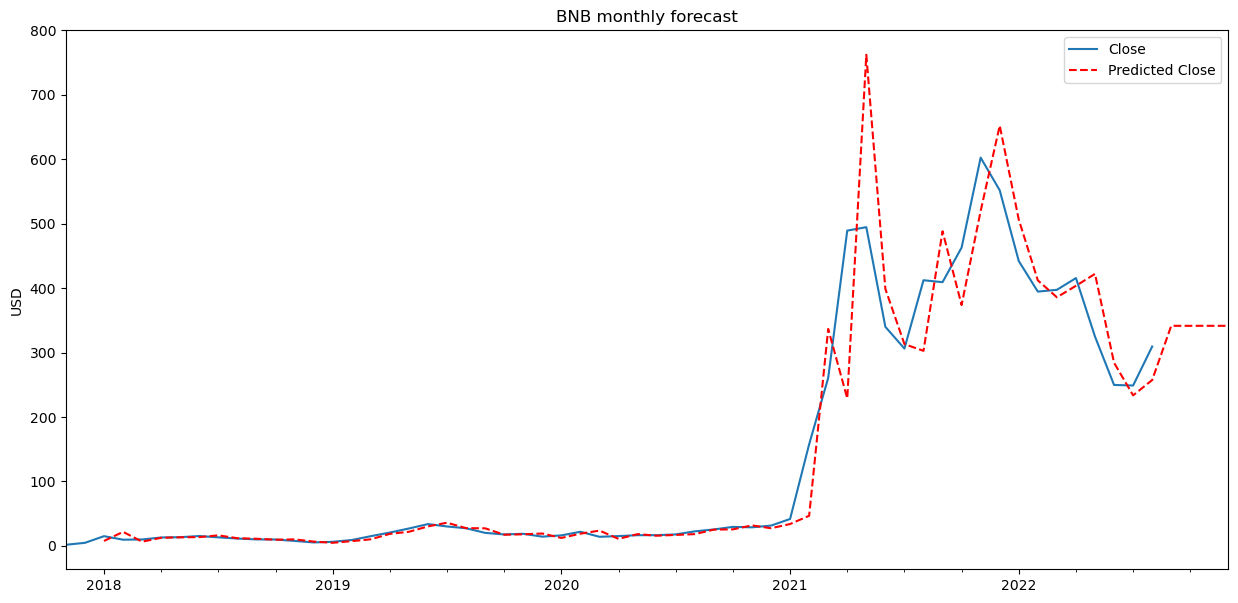

In [21]:
# Prediction
bnb_month_pred = bnb_month[['Close']]
date_list = [datetime(2022, 9, 30), datetime(2022, 10, 31), datetime(2022, 11, 30), datetime(2022, 12, 31)]
future = pd.DataFrame(index=date_list, columns= bnb_month.columns)
bnb_month_pred = pd.concat([bnb_month_pred, future])

bnb_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2022, 12, 31)), lmbda)


plt.figure(figsize=(15,7))
bnb_month_pred.Close.plot()
bnb_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('BNB monthly forecast')
plt.ylabel('USD')
plt.show()

In [22]:
y_forecasted = bnb_month_pred.forecast
y_truth = bnb_month_pred['2018-01-01':'2021-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 4.13
